In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/641.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/173.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/815.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/491.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/718.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/709.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/379.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/780.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/248.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/94.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/480.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/236.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/771.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/675.png
/kaggle/input/image-s

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping

# Residual Unit with two Conv layers and a residual connection
def residual_unit(input_tensor, filters, kernel_size=3):
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    return layers.Add()([input_tensor, x])  # Local residual connection

# Recursive Block (with shared weights among residual units)
def recursive_block(input_tensor, num_residual_units, filters):
    x = input_tensor
    for _ in range(num_residual_units):
        x = residual_unit(x, filters)
    return x

# DRRN Model
def DRRN(input_shape, num_recursive_blocks, num_residual_units, filters):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)

    # Recursive blocks with residual connections
    for _ in range(num_recursive_blocks):
        x = recursive_block(x, num_residual_units, filters)

    # Output Conv Layer to reconstruct residual image
    x = layers.Conv2D(3, (3, 3), padding='same')(x)

    # Global Residual Learning (add the input LR image to the predicted residual)
    outputs = layers.Add()([inputs, x])

    # Build model
    model = models.Model(inputs, outputs)
    return model

# Define the input shape (LR image), number of recursive blocks, residual units, and filters
input_shape = (31, 31, 3)  # (height, width, channels)
num_recursive_blocks = 3  # Number of recursive blocks
num_residual_units = 9    # Number of residual units in each block
filters = 64              # Number of filters in Conv layers

# Build the DRRN model
drrn_model = DRRN(input_shape, num_recursive_blocks, num_residual_units, filters)

# Gradient Clipping with Adam optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # You can adjust this learning rate
    clipnorm=1.0  # This clips gradients to a maximum L2 norm of 1.0
)

# Compile the model with gradient clipping
drrn_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Print the model summary
drrn_model.summary()
   


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 31, 31, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 31, 31,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 31, 31,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 31, 31,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ conv2d[0][0],     │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 31,    │     36,928 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 31, 31,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 31,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 31, 31,    │          0 │ add[0][0],        │
│                     │ 64)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 31, 31,    │     36,928 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 31, 31,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 31, 31,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 31, 31,    │          0 │ add_1[0][0],      │
│                     │ 64)               │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 31, 31,    │     36,928 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 31, 31,    │          0 │ conv2d_7[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 31, 31,    │     36,928 │ activation_3[0][

 Total params: 1,997,635 (7.62 MB)

 Trainable params: 1,997,635 (7.62 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import numpy as np
import os
import cv2

# Function to extract 31x31 patches with a stride of 21 from a single image
def extract_patches(image, patch_size=31, stride=21):
    patches = []
    h, w, _ = image.shape
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    return np.array(patches)

# Function to load images from a directory and extract low-res and high-res patches
def load_and_extract_patches(low_res_dir, high_res_dir, patch_size=31, stride=21):
    low_res_patches = []
    high_res_patches = []

    # Assuming filenames are identical for both low-res and high-res images
    for file_name in os.listdir(low_res_dir):
        # Load low-resolution image
        low_res_image_path = os.path.join(low_res_dir, file_name)
        low_res_image = cv2.imread(low_res_image_path)
        
        # Load high-resolution image
        high_res_image_path = os.path.join(high_res_dir, file_name)
        high_res_image = cv2.imread(high_res_image_path)
        
        # Ensure both images have at least patch_size dimensions and are the same size
        if (low_res_image.shape[0] >= patch_size and low_res_image.shape[1] >= patch_size and
            high_res_image.shape == low_res_image.shape):
            
            # Extract patches from both low-res and high-res images
            low_res_patches.extend(extract_patches(low_res_image, patch_size, stride))
            high_res_patches.extend(extract_patches(high_res_image, patch_size, stride))
    
    return np.array(low_res_patches), np.array(high_res_patches)

# Define the paths to your low-resolution and high-resolution images
low_res_dir = "/kaggle/input/image-super-resolution/dataset/Raw Data/low_res"
high_res_dir = "/kaggle/input/image-super-resolution/dataset/Raw Data/high_res"

# Extract low-res and high-res patches
X_train, Y_train = load_and_extract_patches(low_res_dir, high_res_dir, patch_size=31, stride=21)

# Normalize the patches (if necessary)
X_train = X_train / 255.0  # Normalize low-res patches (input)
Y_train = Y_train / 255.0  # Normalize high-res patches (target)

# Reshape the data for model input
X_train = X_train.reshape(-1, 31, 31, 3)  # Low-res patches
Y_train = Y_train.reshape(-1, 31, 31, 3)  # High-res patches

print(f"Extracted {X_train.shape[0]} patches of size 31x31 from the dataset.")

Extracted 103455 patches of size 31x31 from the dataset.


In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best validation loss
)

history = drrn_model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping]  # Include the early stopping callback
)

# Save the trained model
drrn_model.save("drrn_super_resolution.h5")


Epoch 1/50


I0000 00:00:1727741531.243890      70 service.cc:145] XLA service 0x7afe58004c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727741531.243945      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727741540.093197      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


728/728 ━━━━━━━━━━━━━━━━━━━━ 160s 187ms/step - accuracy: 0.7045 - loss: 17364.8105 - val_accuracy: 0.8540 - val_loss: 0.0011
Epoch 2/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 174ms/step - accuracy: 0.8589 - loss: 0.0011 - val_accuracy: 0.8773 - val_loss: 0.0011
Epoch 3/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 174ms/step - accuracy: 0.8674 - loss: 0.0010 - val_accuracy: 0.8836 - val_loss: 0.0010
Epoch 4/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 174ms/step - accuracy: 0.8712 - loss: 9.9177e-04 - val_accuracy: 0.9108 - val_loss: 0.0010
Epoch 5/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 174ms/step - accuracy: 0.8725 - loss: 9.6890e-04 - val_accuracy: 0.8818 - val_loss: 0.0010
Epoch 6/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 174ms/step - accuracy: 0.8760 - loss: 9.4160e-04 - val_accuracy: 0.8801 - val_loss: 9.9107e-04
Epoch 7/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 174ms/step - accuracy: 0.8768 - loss: 9.3618e-04 - val_accuracy: 0.8931 - val_loss: 9.8502e-04
Epoch 8/50
728/728 ━━━━━━━━━━━━━━━━━━━━ 127s 175ms/step - a

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


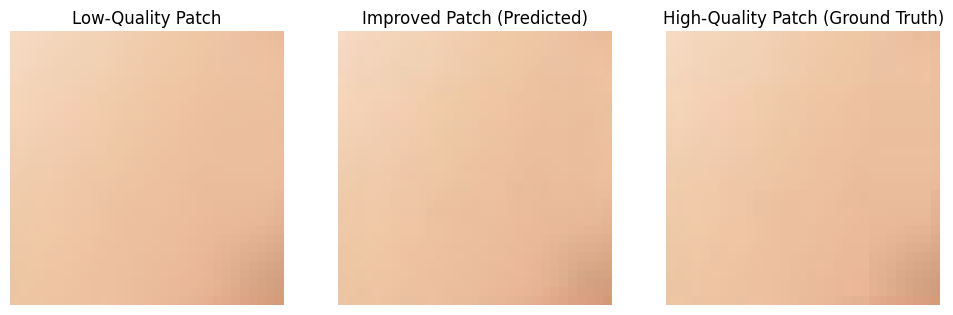

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


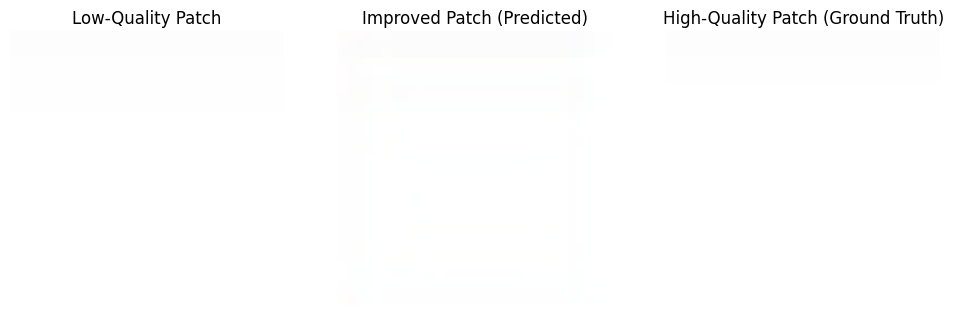

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


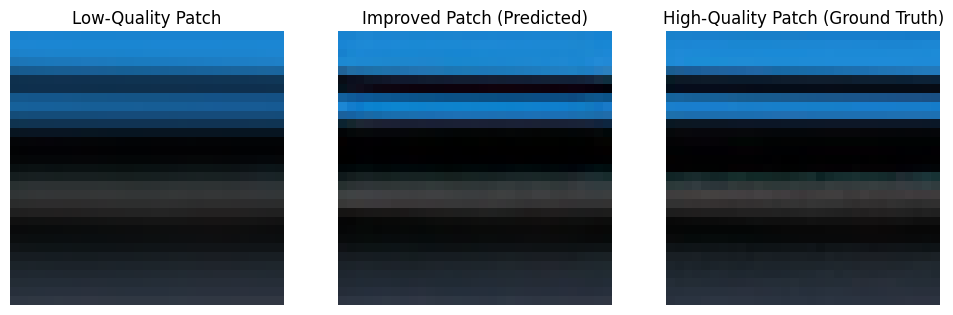

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


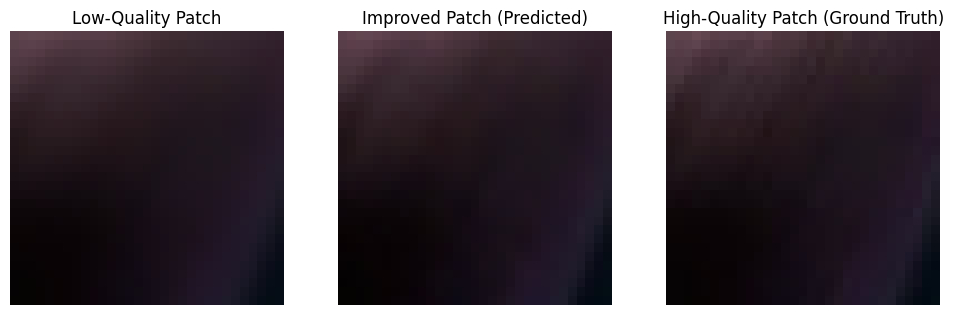

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


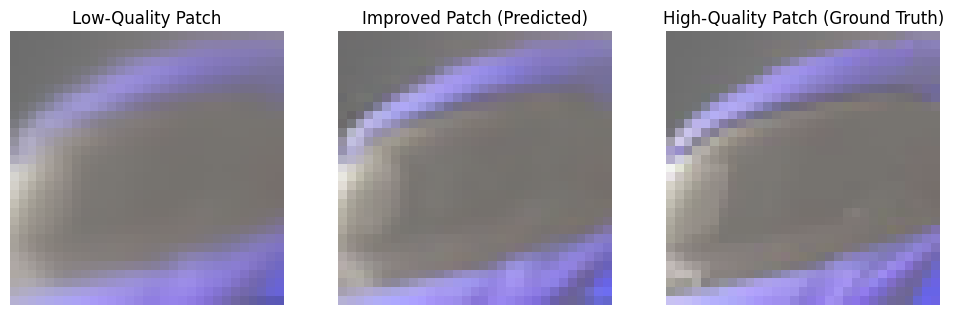

In [5]:
import random
import matplotlib.pyplot as plt
def show_random_patch(X_train, Y_train, model, num_patches=5):
    # Select random indices from the dataset
    indices = random.sample(range(X_train.shape[0]), num_patches)
    
    for idx in indices:
        # Get the low-quality patch (input)
        low_quality_patch = X_train[idx]
        
        # Get the high-quality patch (ground truth)
        high_quality_patch = Y_train[idx]
        
        # Predict the improved patch using the DRRN model
        low_quality_patch_input = low_quality_patch[np.newaxis, ...]  # Add batch dimension
        improved_patch = model.predict(low_quality_patch_input)[0]  # Remove batch dimension
        
        # Plot the low-quality, improved, and high-quality patches side-by-side
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(low_quality_patch)
        axes[0].set_title("Low-Quality Patch")
        axes[0].axis('off')

        axes[1].imshow(improved_patch)
        axes[1].set_title("Improved Patch (Predicted)")
        axes[1].axis('off')

        axes[2].imshow(high_quality_patch)
        axes[2].set_title("High-Quality Patch (Ground Truth)")
        axes[2].axis('off')

        plt.show()

# Example usage: show 5 random patches from the dataset
show_random_patch(X_train, Y_train, drrn_model, num_patches=5)